In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql
from mysql.connector import Error
import clmm
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

In [2]:
#cluster
lens_cat = np.load('../data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl', allow_pickle = True)

In [3]:
rmax = 10

In [4]:
n = 1000
dx = 10*(np.random.random(n)*(-2) +1)
dy = 10*(np.random.random(n)*(-2) +1)
mask = dx**2 + dy**2 < 100

In [5]:
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']

In [6]:
healpix_clusters_window = []
for lens in lens_cat:
    z, ra, dec = lens['redshift'], lens['ra'], lens['dec']
    lens_distance =cosmo.eval_da(z)
    theta_apperture_deg = (180/np.pi)*rmax/lens_distance
    x_rand, y_rand = ra + (180/np.pi)*dx/lens_distance, dec+(180/np.pi)*dy/lens_distance
    healpix_clusters_window.append(np.unique(healpy.pixelfunc.ang2pix(32, x_rand, y_rand, nest=False, lonlat=True)))

In [7]:
mask = []
for hp_list in healpix_clusters_window:
    isin = np.isin(hp_list, healpix_dc2)
    if len(isin[isin==False]!=0):
        mask.append(False)
    else:mask.append(True)
mask = np.array(mask)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


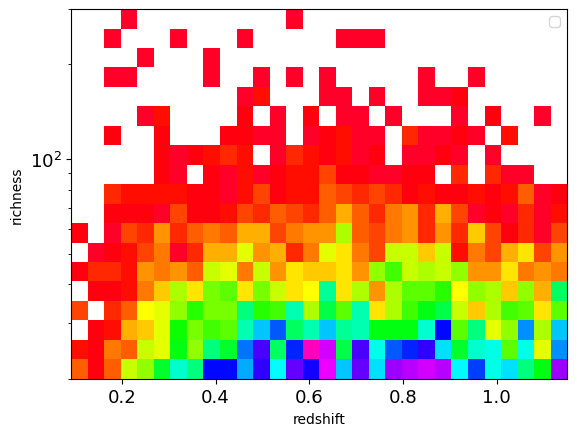

In [8]:
plt.hist2d(lens_cat['redshift'], lens_cat['richness'], cmap = 'gist_rainbow', bins=[30, np.logspace(np.log10(20), np.log10(300), 20)], cmin=1)
plt.yscale('log')
plt.xlabel('redshift')
plt.ylabel('richness')
plt.legend(loc = 'upper right')
plt.tick_params(axis='both', which="both", labelsize= 13)

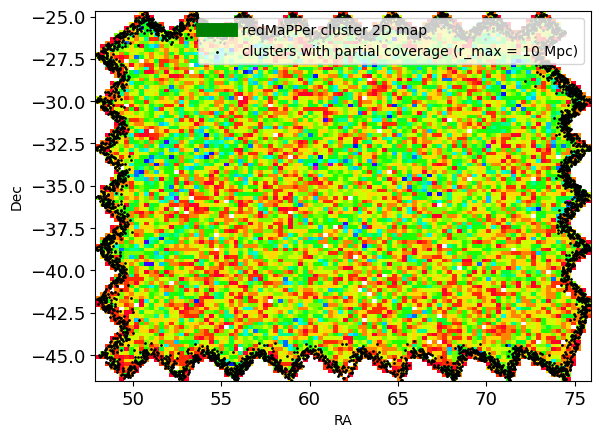

In [9]:
plt.hist2d(lens_cat['ra'], lens_cat['dec'], cmin=1, bins=100, cmap='gist_rainbow')
plt.plot([], [], 'g', lw=10, label = 'redMaPPer cluster 2D map')
plt.scatter(lens_cat['ra'][np.invert(mask)], lens_cat['dec'][np.invert(mask)], s=1, color = 'k', label = 'clusters with partial coverage (r_max = 10 Mpc)')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend(loc = 'upper right')
plt.tick_params(axis='both', which="both", labelsize= 13)

In [16]:
np.save('cluster_id_with_partial_coverage', {'cluster_id_partial_coverage': lens_cat[np.invert(mask)]['cluster_id']},)